In [1]:
!pip install pyscrew sktime mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.9/95.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 45.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 58.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.9/722.9 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━

In [2]:
from pyscrew import get_data
from sktime.classification.dictionary_based import MUSE
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sktime.utils import mlflow_sktime  
import pickle

data = get_data(scenario="s03")

df = pd.DataFrame(data)

# X = df.drop('workpiece_result', axis=1)
# y = df['workpiece_result']

def create_timeseries_from_row(row_data, series_column_name, index_column_name):
    ts_data = row_data[series_column_name]
    time_idx = row_data[index_column_name]

    return pd.Series(data=ts_data, index=pd.Index(time_idx, name='time'))

def createDataset(df, target='class_values'):
    # Antara class_values atau workpiece_result
    X = df.drop(target, axis=1)
    y = df[target]
    XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=42, test_size=0.2)
    return XTrain, XTest, yTrain, yTest

def convertToTimeSeries(X, y, torque=True, angle=True, gradient=True, step=True, target='class_values'):
    torque_series_column = []
    angle_series_column = []
    gradient_series_column = []
    step_values_series_column = []

    for idx, row in X.iterrows(): # Use iterrows to easily get the index
        torque_series_column.append(create_timeseries_from_row(row, 'torque_values', 'time_values'))
        angle_series_column.append(create_timeseries_from_row(row, 'angle_values', 'time_values'))
        gradient_series_column.append(create_timeseries_from_row(row, 'gradient_values', 'time_values'))
        step_values_series_column.append(create_timeseries_from_row(row, 'step_values', 'time_values'))

    X_sktime = pd.DataFrame()

    if torque:
        torque_series_column = pd.Series(torque_series_column, index=X.index) # Reconstruct Series with original index
        X_sktime['torque'] = torque_series_column
    if angle:
        angle_series_column = pd.Series(angle_series_column, index=X.index) # Reconstruct Series with original index
        X_sktime['angle'] = angle_series_column
    if gradient:
        gradient_series_column = pd.Series(gradient_series_column, index=X.index) # Reconstruct Series with original index
        X_sktime['gradient'] = gradient_series_column
    if step:
        step_values_series_column = pd.Series(step_values_series_column, index=X.index) # Reconstruct Series with original index
        X_sktime['step'] = step_values_series_column

    y_labels = y.to_numpy()
    return (X_sktime, y_labels)

def trainModel(X_train, X_test, y_train, y_test, modelName):
    muse = MUSE()
    # Single
    # X_sktime, y_labels = convertToTimeSeries(XTest, yTest, angle=False, gradient=False, step=False)

    muse.fit(X_train, y_train)
    muse_predictions  = muse.predict(X_test) # 53,5% / 56,4%
    muse_cm = confusion_matrix(y_test, muse_predictions)
    print(sklearn.metrics.accuracy_score(y_test, muse_predictions))
    disp = ConfusionMatrixDisplay(confusion_matrix=muse_cm,display_labels=muse.classes_)
    
    disp.plot()

    # mlflow_sktime.save_model(sktime_model=muse, path="/kaggle/working/" + modelName)
    with open(modelName+".pkl", "wb") as f:
        pickle.dump(muse, f)

2025-05-31 06:49:48 - INFO - pyscrew.main - Starting data retrieval for scenario: s03 (assembly-conditions-1)
2025-05-31 06:49:48 - INFO - pyscrew.pipeline.loading - Using cache directory (absolute): /usr/local/lib/python3.11/dist-packages/pyscrew/downloads
2025-05-31 06:49:48 - INFO - pyscrew.pipeline.loading - Beginning data extraction for scenario 's03_variations-in-assembly-conditions-1.zip' (force=False)
2025-05-31 06:49:48 - INFO - pyscrew.pipeline.loading - Downloading dataset 's03_variations-in-assembly-conditions-1.zip' from Zenodo URL: https://zenodo.org/records/15393134/files/s03_variations-in-assembly-conditions-1.zip?download=1


2025-05-31 06:49:51 - INFO - pyscrew.pipeline.loading - Download of 's03_variations-in-assembly-conditions-1.zip' completed (12,588,324 bytes). Beginning checksum verification...
2025-05-31 06:49:51 - INFO - pyscrew.pipeline.loading - Verifying MD5 checksum for 's03_variations-in-assembly-conditions-1.zip'...
2025-05-31 06:49:51 - INFO - pyscrew.pipeline.loading - Checksum verification successful for 's03_variations-in-assembly-conditions-1.zip' (MD5: 91b7113d1130f4d06d63c681c1897fef)


2025-05-31 06:49:51 - INFO - pyscrew.pipeline.loading - Extracting archive 's03_variations-in-assembly-conditions-1.zip' to directory: /usr/local/lib/python3.11/dist-packages/pyscrew/downloads/extracted/s03_variations-in-assembly-conditions-1
2025-05-31 06:49:52 - INFO - pyscrew.pipeline.loading - Extraction of 's03_variations-in-assembly-conditions-1.zip' completed successfully to: /usr/local/lib/python3.11/dist-packages/pyscrew/downloads/extracted/s03_variations-in-assembly-conditions-1
2025-05-31 06:49:52 - INFO - pyscrew.core.dataset - Selected 1700 files
2025-05-31 06:49:54 - INFO - pyscrew.core.dataset - Successfully loaded 1700 screw runs
2025-05-31 06:49:54 - INFO - pyscrew.pipeline.processing - Adding input_logging transformer to pipeline
2025-05-31 06:49:54 - INFO - pyscrew.pipeline.processing - Adding step_unpacking transformer to pipeline
2025-05-31 06:49:54 - INFO - pyscrew.pipeline.processing - Adding duplicate handling with first
2025-05-31 06:49:54 - INFO - pyscrew.pipe

2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_missings - Completed missing interpolation using 'mean' method (interval=0.0012)
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_missings - Processed 1,700 series with 1,294,443 total points
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_missings - Found gaps - min: 0.0012s, max: 0.1116s, avg: 0.0013s
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_missings - Added 67,179 points (+5.19% of total)
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_missings - Average 39.5 points added per series
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_lengths - Starting to apply equal lengths.
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_lengths - - 'target_length' : 1000
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transformers.handle_lengths - - 'padding_value' : 0.0
2025-05-31 06:50:32 - INFO - pyscrew.pipeline.transform

2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.handle_lengths - Finished applying equal lengths to the screw driving data.
2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.handle_lengths - - Total screw runs loaded:	1700
2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.handle_lengths - - Average change of length:	800.95 -> 1000.00
2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.handle_lengths - - Total points before normalization:	1,361,622
2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.handle_lengths - - Total points after normalization:	1,700,000
2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.convert_dataset - Output format is 'list' - keeping the default format
2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.pipeline_logging - Output - Fit: Dataset contains 1700 runs
2025-05-31 06:50:33 - INFO - pyscrew.pipeline.transformers.pipeline_logging - time_values: 1700 runs
2025-05-31 06:50:33 - INFO - pyscrew.pip

In [15]:
# Model
# Antara class_values atau workpiece_result
XTrain, XTest, yTrain, yTest = createDataset(df, target='class_values')
# XTrain, XTest, yTrain, yTest = createDataset(df, target='workpiece_result')

In [16]:
# XTrain_time, yTrain_label = convertToTimeSeries(X=XTrain, y=yTrain, torque=True, angle=False, gradient=False, step=False, target='workpiece_result')
# XTest_time, yTest_label = convertToTimeSeries(X=XTest, y=yTest, torque=True, angle=False, gradient=False, step=False, target='workpiece_result')

XTrain_time, yTrain_label = convertToTimeSeries(X=XTrain, y=yTrain, torque=True, angle=True, gradient=True, step=True, target='class_values')
XTest_time, yTest_label = convertToTimeSeries(X=XTest, y=yTest, torque=True, angle=True, gradient=True, step=True, target='class_values')

0.5441176470588235


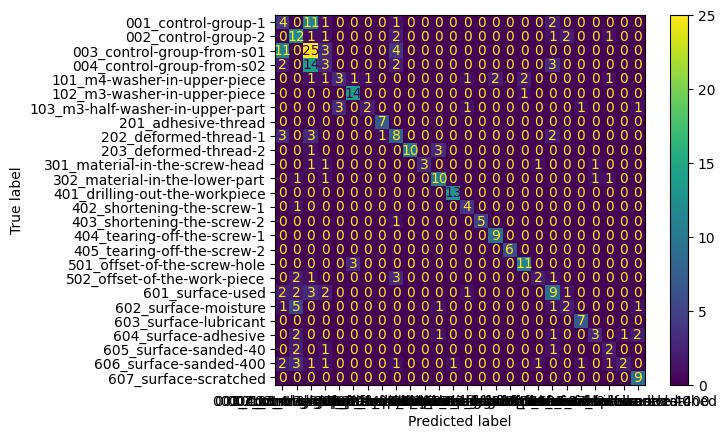

In [17]:
trainModel(XTrain_time, XTest_time, yTrain_label, yTest_label, "TorqueAngleGradientStep_Multi_ClassValues")

In [18]:
import pickle

with open("/kaggle/working/TorqueAngleGradientStep_Multi_ClassValues.pkl", "rb") as f:
    muse_loaded = pickle.load(f)

# Now you can use muse_loaded to make predictions
predictions = muse_loaded.predict(XTest_time)

In [19]:
print(sklearn.metrics.accuracy_score(yTest_label, predictions))

0.5441176470588235
